# Analysis and Comparison of Stitching Algorithms

This notebook performs an analysis and comparison of different stitching algorithms used in image processing. The objective is to evaluate the performance and accuracy of these algorithms based on various metrics.

In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt
import scipy

# Functions needed for the analysis

In [2]:
def load_subject(subject, data_directory, threshold):
    """
    Load and reformat cell data for a given subject.

    This function reads cell data from a CSV file for a specified subject,
    applies a reformatting function to the data, and returns the reformatted DataFrame.

    Parameters:
    subject (str): The subject identifier.
    data_directory (str): The directory containing the subject data.
    threshold (int): The threshold value used in the file naming.

    Returns:
    pd.DataFrame: The reformatted cell data for the subject.
    """
    
    # Construct the file suffix based on the threshold
    file_suffix = 'cells' + str(threshold)
    
    # Load the cell data from the specified CSV file
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    
    # Reformat the loaded DataFrame using ace.reformat_df_mouse
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    # Return the reformatted DataFrame
    return df_mouse

In [3]:
def print_results(experimental_groups, groups_df, area=None):
    """
    Print the results for each experimental group.

    This function prints the summary statistics for each experimental group from
    the provided DataFrame. If an area is specified, it prints the results for that
    specific area. Otherwise, it prints the overall summary.

    Parameters:
    experimental_groups (dict): Dictionary of experimental group identifiers.
    groups_df (list of pd.DataFrame): List of DataFrames containing the results for each group.
    area (str, optional): Specific area to print results for. If None, prints the overall summary.

    Returns:
    None
    """
    
    # Iterate over each experimental group and its corresponding DataFrame
    for i, df in zip(experimental_groups.keys(), groups_df):
        # Print the group identifier
        print(i)
        
        if area is None:
            # Print the overall summary if no specific area is provided
            print(df.set_index('area').sum().to_string())
        else:
            # Print the results for the specified area
            print(df.set_index('area').loc[area].to_string())
        
        # Print a blank line for separation between groups
        print(' ')


In [4]:
def make_df(dictionary, area=None, unstack=False):
    """
    Create a DataFrame from a nested dictionary.

    This function takes a nested dictionary and flattens it to create a DataFrame.
    It can optionally filter by a specific area and unstack the DataFrame.

    Parameters:
    dictionary (dict): Nested dictionary to be converted into a DataFrame.
    area (str, optional): Specific area to filter the data. If None, includes all areas.
    unstack (bool, optional): If True, unstacks the DataFrame to have specific columns.

    Returns:
    pd.DataFrame: Flattened and optionally filtered/unstacked DataFrame.
    """
    data = dictionary

    # Flatten the nested dictionary and create a DataFrame
    if area is None:
        # Create DataFrame from the nested dictionary summing up the values
        df = pd.DataFrame.from_dict(
            {(level1, level2, level3): value.sum()
             for level1, inner_dict in data.items()
             for level2, inner_inner_dict in inner_dict.items()
             for level3, value in inner_inner_dict.items() if level3 != 'area'},
            orient='index'
        )
    else:
        # Create DataFrame from the nested dictionary filtering by the specified area
        df = pd.DataFrame.from_dict(
            {(level1, level2, level3): value
             for level1, inner_dict in data.items()
             for level2, inner_inner_dict in inner_dict.items()
             for level3, value in inner_inner_dict.set_index('area').loc[area].items() if level3 != 'area'},
            orient='index'
        )

    # Set MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index)

    if unstack:
        # Unstack and obtain terastitcher and bigstitcher as columns
        df = df.unstack(level=0)
        df.columns = df.columns.droplevel(0)
    else:
        # Reset the index to use MultiIndex as columns
        df.reset_index(inplace=True)
        # Rename the columns
        df.columns = ['Stitcher', 'Subject', 'Measure', 'Value']

    return df

In [5]:
def plot_differences(df):
    """
    Plot differences between subjects for each measure.

    This function creates bar plots to compare the values of different measures 
    between subjects, grouped by 'Stitcher'. The plots are displayed in a 2x2 grid.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot. 
                       It must have columns 'Subject', 'Value', 'Stitcher', and 'Measure'.
    """
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Get unique measures from the DataFrame
    measures = df['Measure'].unique()

    # Iterate over the subplots and measures
    for ax, measure in zip(axs.flatten(), measures):
        # Filter data for the current measure
        data_measure = df[df['Measure'] == measure]

        # Create a bar plot for the current measure
        sns.barplot(x='Subject', y='Value', hue='Stitcher', data=data_measure, ax=ax)

        # Set the title of the subplot to the current measure
        ax.set_title(measure)

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()


In [6]:
def heatmaps(dictionary_results):
    """
    Generate heatmaps showing the differences between bigstitcher and terastitcher
    for each measure across different areas.

    This function creates a dictionary of heatmaps for various measures,
    representing the aggregated differences between 'bigstitcher' and 'terastitcher'
    values across all subjects and areas.

    Parameters:
    dictionary_results (dict): Nested dictionary with results data.
    
    Returns:
    dict: A dictionary where each key is a measure and the value is a NumPy array 
          representing the heatmap of differences for that measure.
    """
    # Create a DataFrame from the dictionary, unstacking the data
    df_tot = make_df(dictionary=dictionary_results, unstack=True)
    
    # Get unique subjects and measures from the DataFrame
    subjects = df_tot.index.get_level_values(0).unique()
    measures = df_tot.index.get_level_values(1).unique()
    
    # Extract the list of areas from the dictionary
    list_areas = dictionary_results['bigstitcher'][subjects[0]]['area'].to_numpy()
    
    # Initialize a dictionary to store heatmaps for each measure
    heatmaps = {n: np.zeros(shape=(len(list_areas))) for n in measures}
    
    # Iterate over each measure
    for i, measure in enumerate(measures):
        # Iterate over each area
        for j, area in enumerate(list_areas):
            # Create a DataFrame for the current area
            df = make_df(dictionary=dictionary_results, area=area, unstack=True)
            
            # Calculate the difference between bigstitcher and terastitcher
            df['difference'] = df['bigstitcher'] - df['terastitcher']
            
            # Accumulate the differences for each subject
            for sub in subjects:
                val = df.loc[(sub, measure), 'difference']
                heatmaps[measure][j] += val
    
    return heatmaps


# Analysis on WILD mice

## Data Loading for WILD mice

In this section, we load the necessary data files required for the analysis.

In [7]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group_bigstitcher = 'WILD_bigstitcher'
data_directory_bigstitcher = root_directory + experiment + '/' \
                + experimental_group_bigstitcher + '/'
subjects_bigstitcher = [name for name in os.listdir(data_directory_bigstitcher) \
            if os.path.isdir(os.path.join(data_directory_bigstitcher, name))]

experimental_group_terastitcher = 'WILD_terastitcher'
data_directory_terastitcher = root_directory + experiment + '/' \
                + experimental_group_terastitcher + '/'
subjects_terastitcher = [name for name in os.listdir(data_directory_terastitcher) \
            if os.path.isdir(os.path.join(data_directory_terastitcher, name))]

In [8]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [9]:
# Uncomment only if you need to recalculate: the creation of the dictionary takes a while

# dict_results_across_mice = {
#     stitcher:{
#     subject: ace.calculate_cells_energy_per_level(
#     df_mouse=load_subject(subject=subject, 
#                           data_directory=data_directory,
#                           threshold=2500),
#     vol=volumes,
#     level=8) for subject in [name for name in os.listdir(data_directory) \
#             if os.path.isdir(os.path.join(data_directory, name))]
#     } for stitcher, data_directory in zip(['terastitcher', 'bigstitcher'],
#                                           [data_directory_terastitcher, data_directory_bigstitcher])}
# np.save('dict_results/dict_results_across_mice_cfr_stitcher.npy', dict_results_across_mice)

In [10]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_cfr_stitcher.npy', 
                                   allow_pickle=True).item()

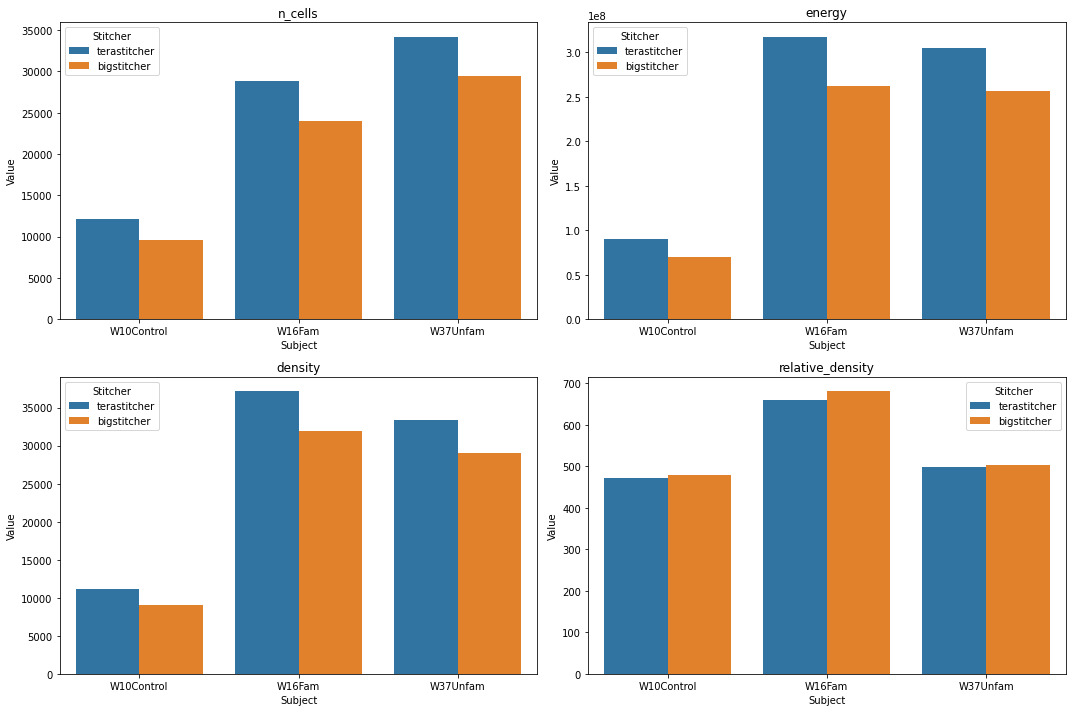

In [11]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area=None))

## Visualization

We use visualizations to better understand the differences between the stitching algorithms.


In [12]:
make_df(dictionary=dict_results_across_mice, area='Main olfactory bulb', unstack=True)

bigstitcher  terastitcher
W10Control density           1.596851e+01  2.254378e+01
           energy            1.211915e+05  1.737697e+05
           n_cells           1.360000e+02  1.920000e+02
           relative_density  8.515405e-01  9.504000e-01
W16Fam     density           3.941638e+02  4.740064e+02
           energy            2.958645e+06  3.625800e+06
           n_cells           3.357000e+03  4.037000e+03
           relative_density  8.400000e+00  8.413082e+00
W37Unfam   density           3.907588e+02  4.871569e+02
           energy            6.047698e+06  7.303648e+06
           n_cells           3.328000e+03  4.149000e+03
           relative_density  6.774671e+00  7.278129e+00

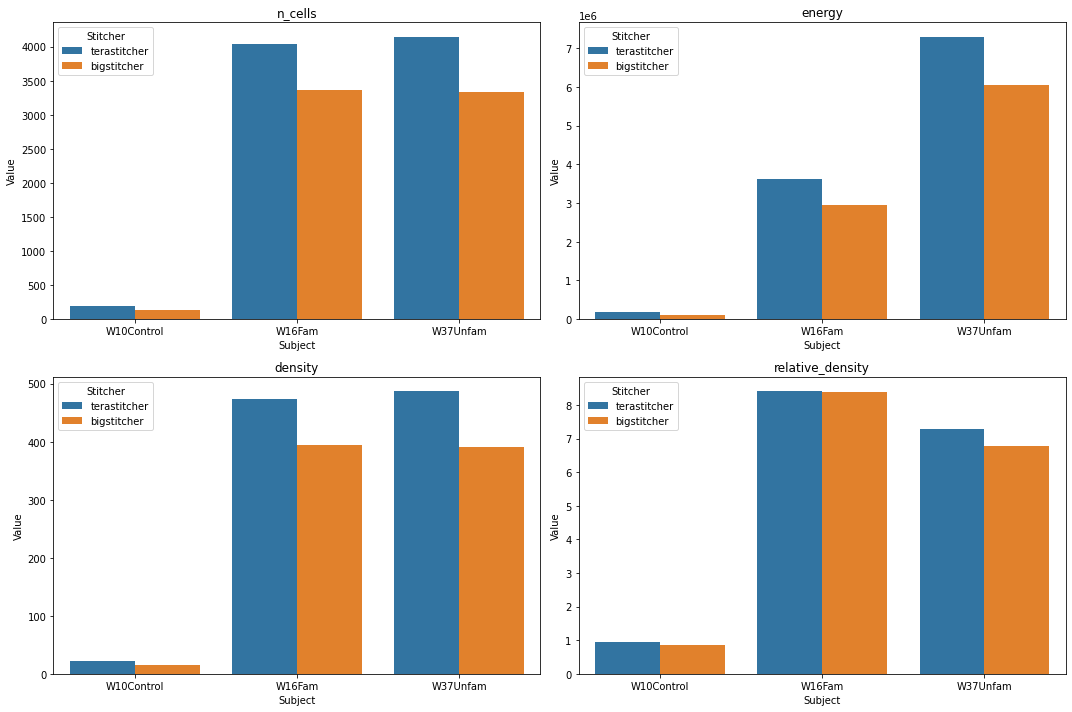

In [13]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Main olfactory bulb'))

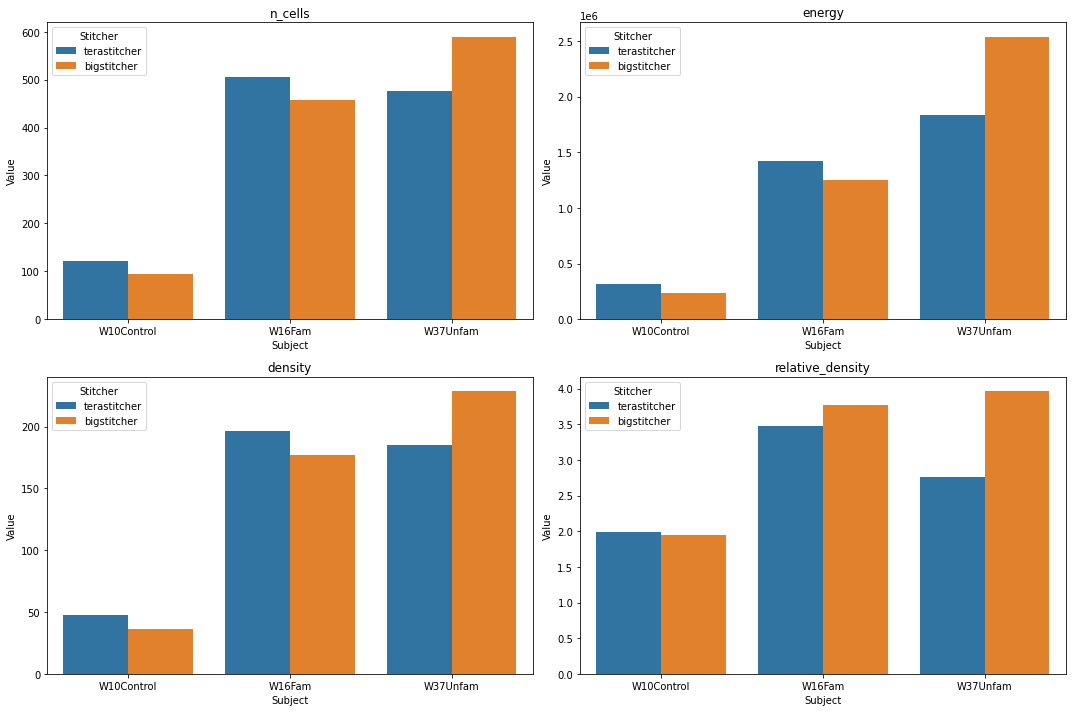

In [14]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Anterior olfactory nucleus'))

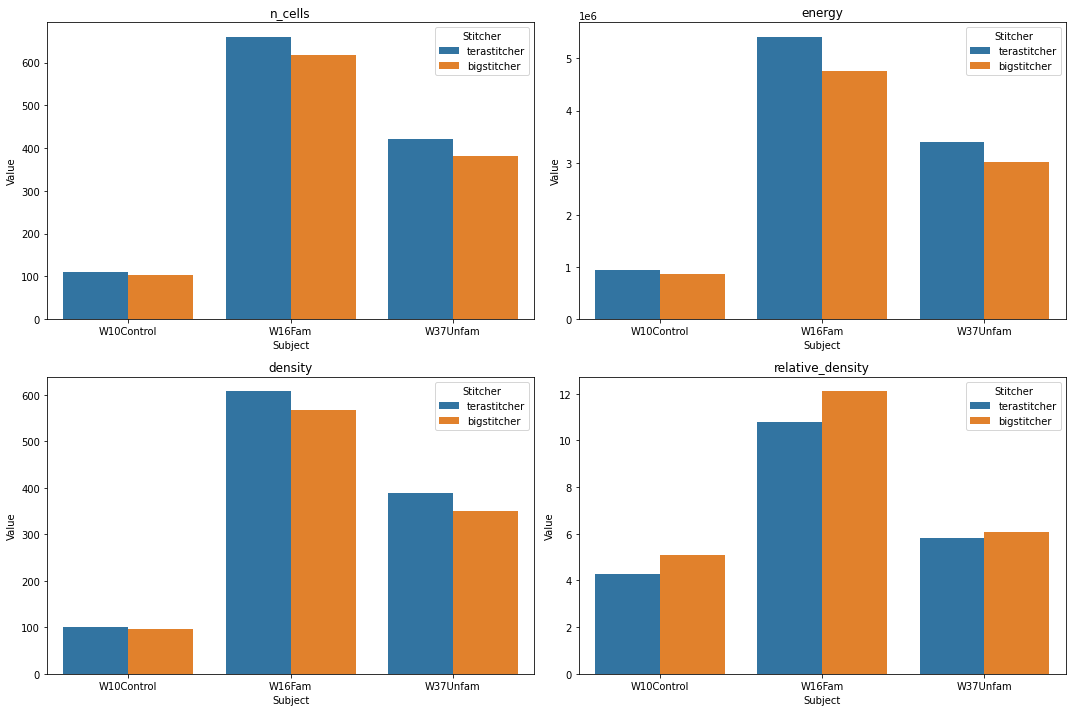

In [15]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Medial amygdalar nucleus'))

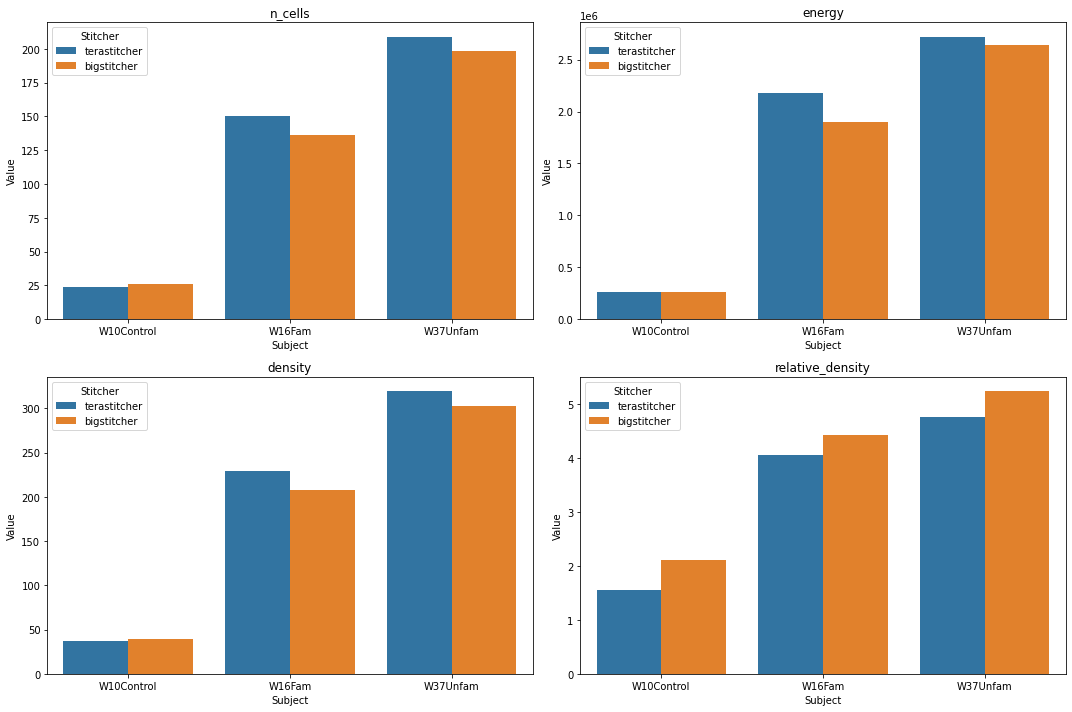

In [16]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Piriform-amygdalar area'))

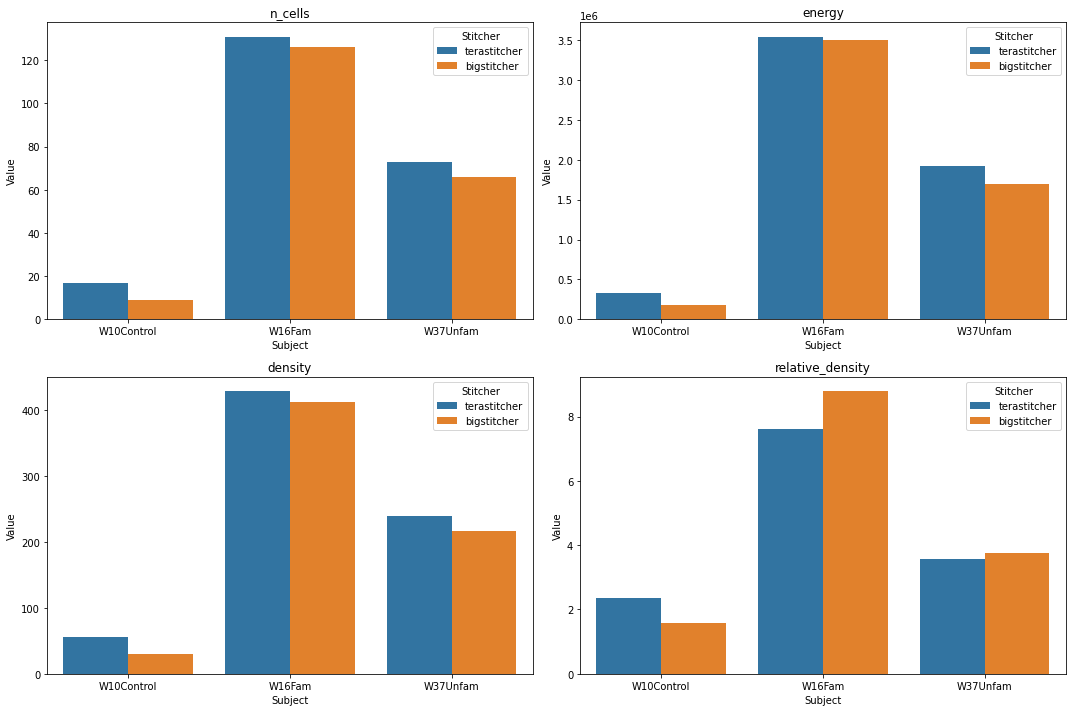

In [17]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Supramammillary nucleus'))

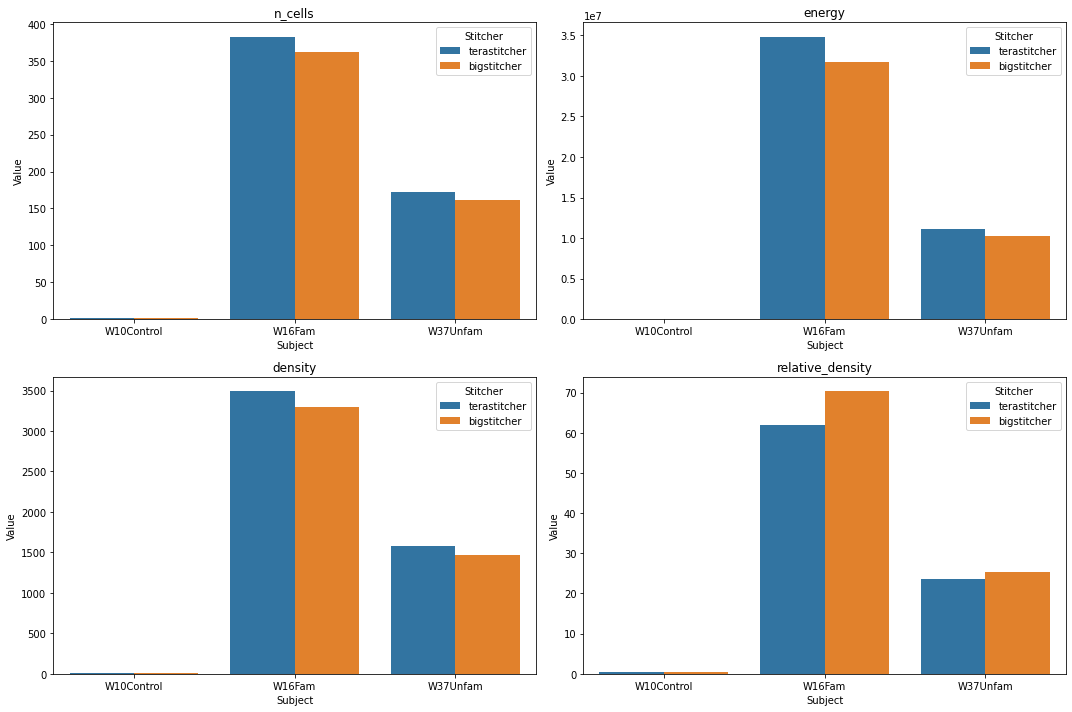

In [18]:
plot_differences(df=make_df(dictionary=dict_results_across_mice, area='Ventral premammillary nucleus'))

### Visualization: Heatmap area differences

In [19]:
heatmaps = heatmaps(dictionary_results=dict_results_across_mice)

<AxesSubplot:>

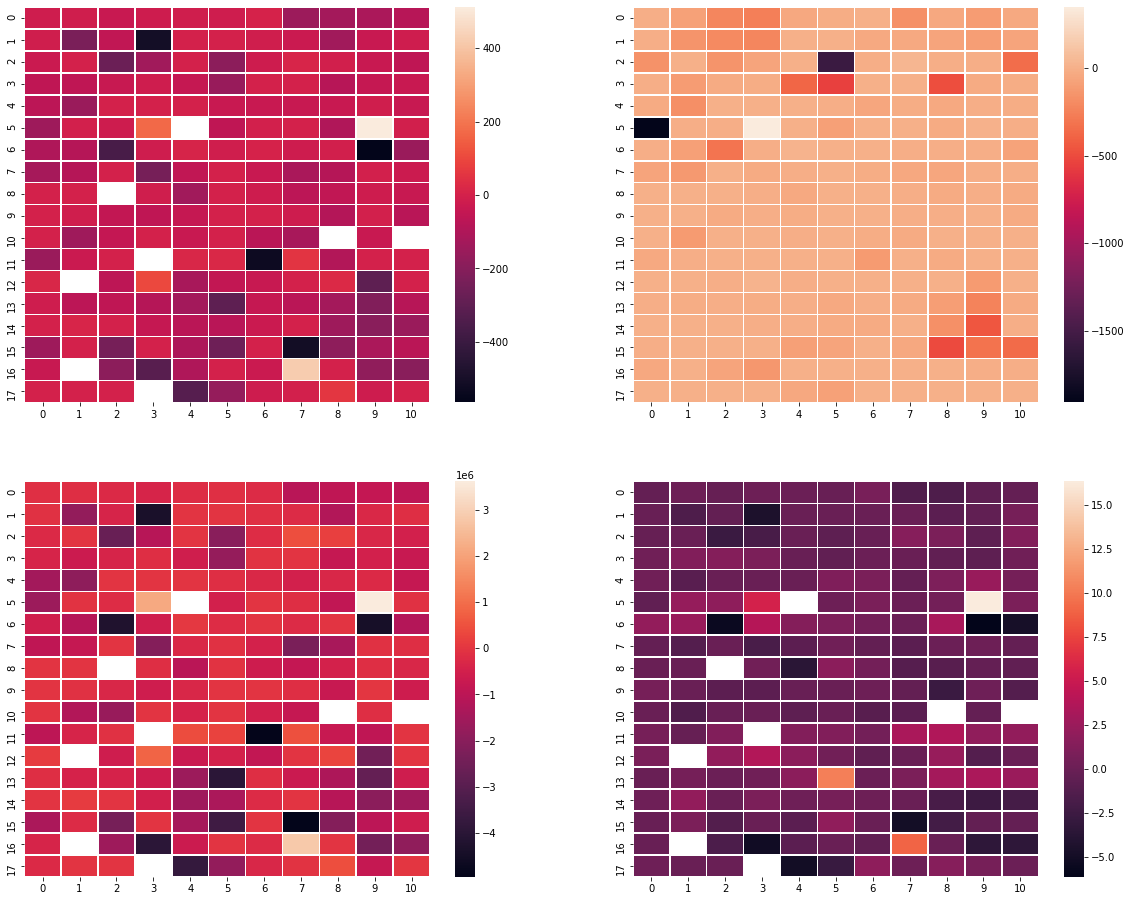

In [20]:
f, axes = plt.subplots(2,2,figsize=(20, 16))
heatmaps_sns = {key:np.reshape(a=value, newshape=(18,11)) for key, value in heatmaps.items()}
sns.heatmap(heatmaps_sns['density'], linewidths=.5, ax=axes[0][0])
sns.heatmap(heatmaps_sns['n_cells'], linewidths=.5, ax=axes[0][1])
sns.heatmap(heatmaps_sns['energy'], linewidths=.5, ax=axes[1][0])
sns.heatmap(heatmaps_sns['relative_density'], linewidths=.5, ax=axes[1][1])

### Visualization: Confronting area density maps

In [21]:
df = make_df(dictionary=dict_results_across_mice, area='Frontal pole cerebral cortex')
subjects = subjects_terastitcher
df['Area'] = ['Frontal pole cerebral cortex' for i in range(len(df))]
area_list = dict_results_across_mice['bigstitcher'][subjects[0]]['area'].to_numpy()
for area in area_list[1:]:
    df1 = make_df(dictionary=dict_results_across_mice, area=area)
    df1['Area'] = [area for i in range(len(df1))]
    df = df.append(df1, ignore_index=True)

<AxesSubplot:xlabel='Value', ylabel='Subject'>

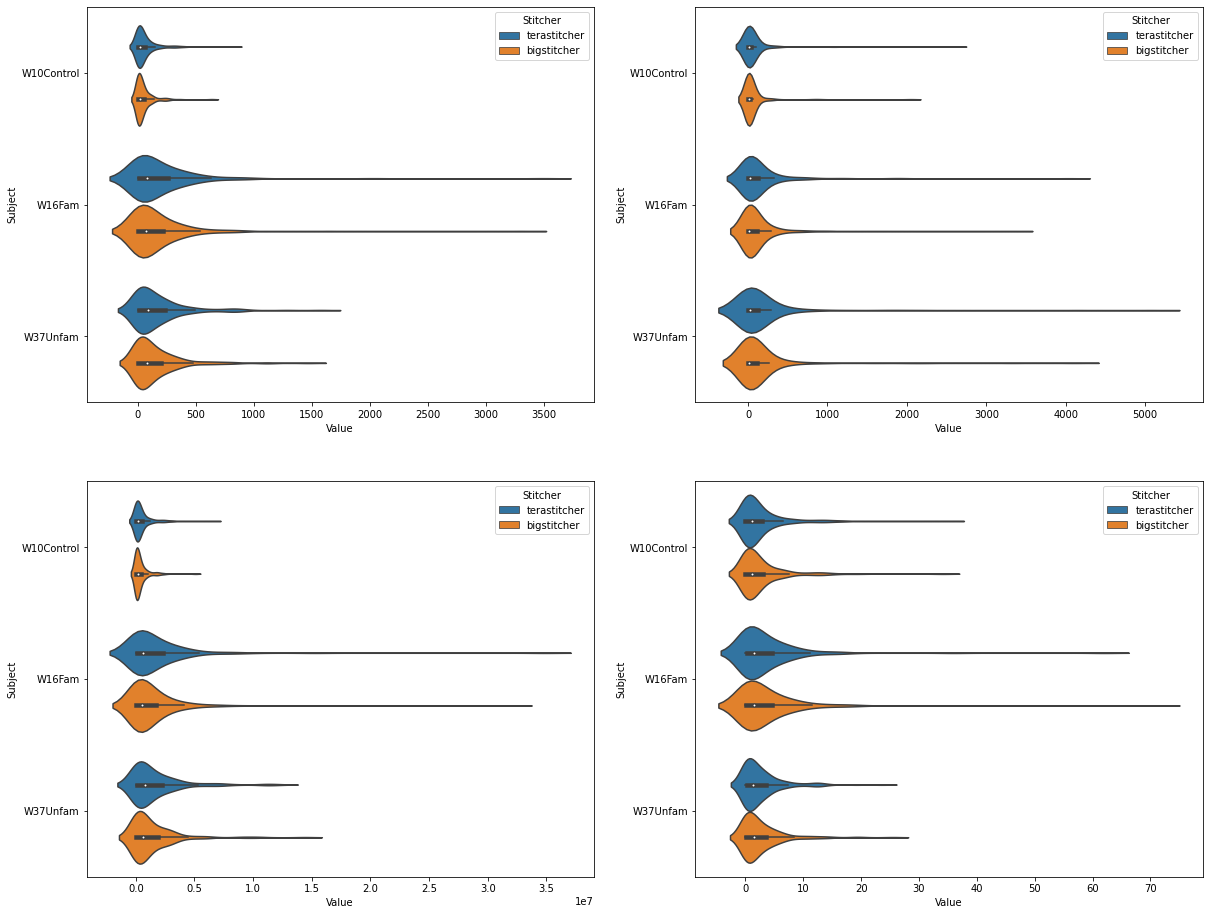

In [22]:
f, axes = plt.subplots(2,2,figsize=(20, 16))
sns.violinplot(y='Subject', x='Value', hue='Stitcher', data=df[df['Measure']=='density'], ax=axes[0][0])
sns.violinplot(y='Subject', x='Value', hue='Stitcher', data=df[df['Measure']=='n_cells'], ax=axes[0][1])
sns.violinplot(y='Subject', x='Value', hue='Stitcher', data=df[df['Measure']=='energy'], ax=axes[1][0])
sns.violinplot(y='Subject', x='Value', hue='Stitcher', data=df[df['Measure']=='relative_density'], ax=axes[1][1])

# Analysis of 1 Whole Brain Dataset

In [23]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'Black_wf_WholeBrain'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subject = 'BL51Control'

In [24]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database()

In [25]:
df_mouse_terastitcher = pd.read_csv(data_directory + subject + '/cells_2500_terastitcher.csv')
df_mouse_terastitcher = ace.reformat_df_mouse(df=df_mouse_terastitcher)
df_mouse_bigstitcher = pd.read_csv(data_directory + subject + '/cells_2500.csv')
df_mouse_bigstitcher = ace.reformat_df_mouse(df=df_mouse_bigstitcher)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [26]:
dict_results_across_mice = {'terastitcher': ace.calculate_cells_energy_per_level(df_mouse=df_mouse_terastitcher, 
                                                                          vol=volumes, 
                                                                          level=8),
                           'bigstitcher': ace.calculate_cells_energy_per_level(df_mouse=df_mouse_bigstitcher, 
                                                                          vol=volumes, 
                                                                          level=8)}

Text(0.5, 1.0, 'Relative Density')

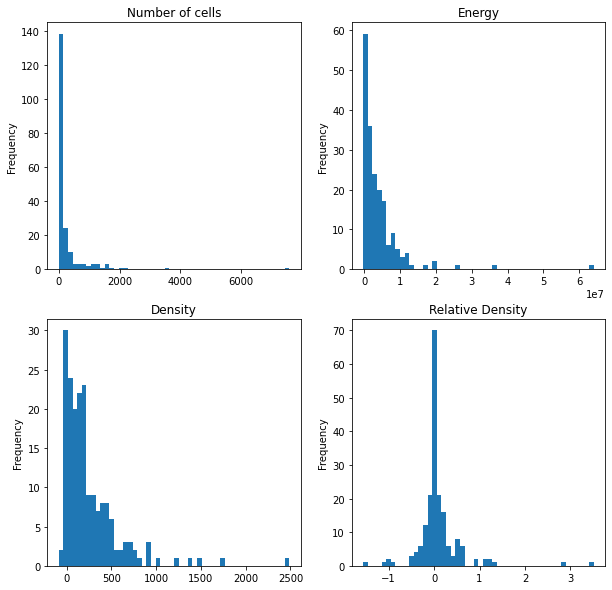

In [27]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
(dict_results_across_mice['terastitcher']['n_cells'] - dict_results_across_mice['bigstitcher']['n_cells']).plot(kind='hist', 
                                                                                             ax=axes[0][0],bins=50)
(dict_results_across_mice['terastitcher']['energy'] - dict_results_across_mice['bigstitcher']['energy']).plot(kind='hist', 
                                                                                             ax=axes[0][1],bins=50)
(dict_results_across_mice['terastitcher']['density'] - dict_results_across_mice['bigstitcher']['density']).plot(kind='hist', 
                                                                                             ax=axes[1][0],bins=50)
(dict_results_across_mice['terastitcher']['relative_density'] - dict_results_across_mice['bigstitcher']['relative_density']).plot(kind='hist', 
                                                                                             ax=axes[1][1],bins=50)
axes[0][0].set_title('Number of cells')
axes[0][1].set_title('Energy')
axes[1][0].set_title('Density')
axes[1][1].set_title('Relative Density')

In [28]:
difference = dict_results_across_mice['terastitcher'].set_index('area') - \
dict_results_across_mice['bigstitcher'].set_index('area')

In [29]:
difference['n_cells'].describe()

count     198.000000
mean      258.515152
std       700.118088
min        -2.000000
25%         3.000000
50%        33.000000
75%       183.750000
max      7580.000000
Name: n_cells, dtype: float64

In [30]:
difference['density'].describe()

count     190.000000
mean      254.470841
std       327.740998
min       -87.711284
25%        49.219979
50%       158.014792
75%       337.208849
max      2487.469738
Name: density, dtype: float64

In [31]:
difference['energy'].describe()

count    1.900000e+02
mean     3.978963e+06
std      6.377171e+06
min     -2.983292e+05
25%      6.620686e+05
50%      2.294170e+06
75%      4.994625e+06
max      6.399724e+07
Name: energy, dtype: float64

In [32]:
# test difference across samples
scipy.stats.wilcoxon((dict_results_across_mice['terastitcher']['density'] - dict_results_across_mice['bigstitcher']['density']).values)

WilcoxonResult(statistic=69.0, pvalue=5.902841559243698e-30)

Text(0, 0.5, 'log(region volume)')

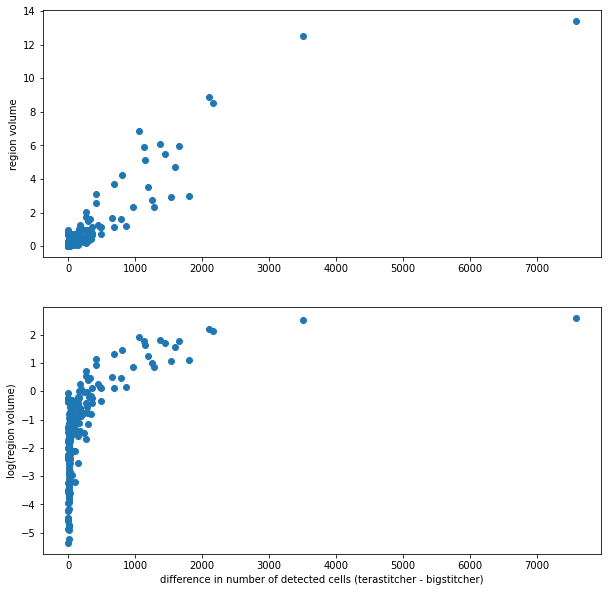

In [33]:
# Plot difference n_cells in function of the volume
vols = [volumes[volumes['safe_name']==area]['CCF_volume'].values[0] for area in difference['n_cells'].index]

fig, axes = plt.subplots(2,1, figsize=(10,10))
axes[0].scatter(y=vols, x=difference['n_cells'])
axes[1].scatter(y=np.log(vols), x=difference['n_cells'])
axes[1].set_xlabel('difference in number of detected cells (terastitcher - bigstitcher)')
axes[0].set_ylabel('region volume')
axes[1].set_ylabel('log(region volume)')

In [34]:
difference['density'].sort_values()[0:20]

area
Lateral terminal nucleus of the accessory optic tract   -87.711284
Suprachiasmatic nucleus                                 -51.484883
Central medial nucleus of the thalamus                   -7.090496
Ectorhinal area                                           0.000000
Posterior triangular thalamic nucleus                     0.000000
Ventromedial preoptic nucleus                             0.000000
Anterior area                                             0.000000
Xiphoid thalamic nucleus                                  0.000000
Perireunensis nucleus                                     0.000000
Postrhinal area                                           0.000000
Intermediate geniculate nucleus                           0.000000
Perifornical nucleus                                      0.000000
Median eminence                                           0.000000
Laterointermediate area                                   0.000000
Paranigral nucleus                                       

In [35]:
difference['density'].sort_values()[-20:]

area
Ventral tegmental area                                 740.367827
Subparafascicular nucleus                              761.346494
Midbrain trigeminal nucleus                            834.005585
Nucleus of the brachium of the inferior colliculus     894.040719
Bed nucleus of the accessory olfactory tract           895.403065
Lateral preoptic area                                  924.597236
Ventral part of the lateral geniculate complex        1017.843005
Preparasubthalamic nucleus                            1239.436620
Medial habenula                                       1378.776403
Bed nucleus of the anterior commissure                1505.144537
Midbrain reticular nucleus retrorubral area           1729.955602
Fasciola cinerea                                      2487.469738
Lateral strip of striatum                                     NaN
Retroethmoid nucleus                                          NaN
Pineal body                                                   NaN
Nucle

In [36]:
np.abs(difference['density']).sort_values()[-30:]

area
Inferior colliculus                                    547.715451
Caudoputamen                                           566.352396
Superior colliculus motor related                      606.370157
Lateral hypothalamic area                              609.281318
Infralimbic area                                       642.107820
Parabigeminal nucleus                                  646.222887
Bed nuclei of the stria terminalis                     666.237738
Subiculum                                              727.706943
Magnocellular nucleus                                  728.321068
Presubiculum                                           736.273700
Ventral tegmental area                                 740.367827
Subparafascicular nucleus                              761.346494
Midbrain trigeminal nucleus                            834.005585
Nucleus of the brachium of the inferior colliculus     894.040719
Bed nucleus of the accessory olfactory tract           895.403065
Later

Text(0, 0.5, 'log(region volume)')

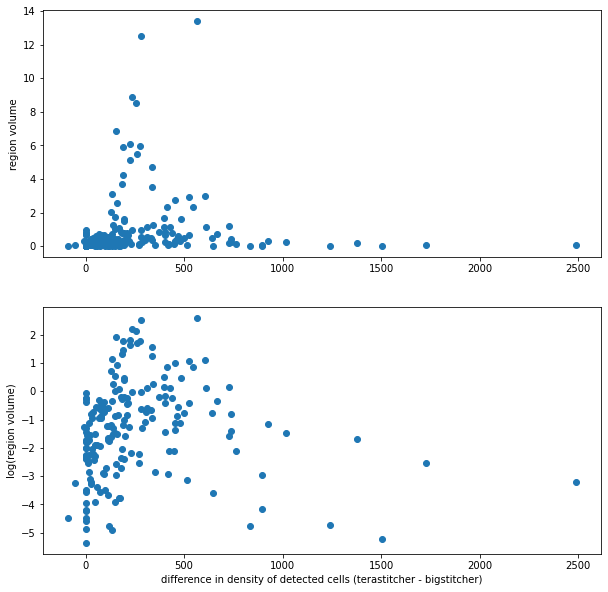

In [37]:
# Plot difference n_cells in function of the volume
vols = [volumes[volumes['safe_name']==area]['CCF_volume'].values[0] for area in difference['n_cells'].index]

fig, axes = plt.subplots(2,1, figsize=(10,10))
axes[0].scatter(y=vols, x=difference['density'])
axes[1].scatter(y=np.log(vols), x=difference['density'])
axes[1].set_xlabel('difference in density of detected cells (terastitcher - bigstitcher)')
axes[0].set_ylabel('region volume')
axes[1].set_ylabel('log(region volume)')

In [38]:
difference['relative_density'].sort_values()[-20:]

area
Bed nuclei of the stria terminalis                    0.616011
Postsubiculum                                         0.622745
Preparasubthalamic nucleus                            0.647950
Nucleus of the brachium of the inferior colliculus    0.953927
Presubiculum                                          0.959721
Lateral preoptic area                                 1.095503
Parabigeminal nucleus                                 1.123507
Medial habenula                                       1.181865
Ventral part of the lateral geniculate complex        1.248149
Midbrain reticular nucleus retrorubral area           1.317620
Bed nucleus of the anterior commissure                2.819622
Fasciola cinerea                                      3.509550
Lateral strip of striatum                                  NaN
Retroethmoid nucleus                                       NaN
Pineal body                                                NaN
Nucleus circularis                                

In [39]:
difference['relative_density'].sort_values()[0:20]

area
Globus pallidus internal segment                        -1.559945
Parasubthalamic nucleus                                 -1.062980
Lateral hypothalamic area                               -1.008286
Perirhinal area                                         -0.968292
Lateral terminal nucleus of the accessory optic tract   -0.882313
Ventromedial hypothalamic nucleus                       -0.515584
Visceral area                                           -0.482685
Orbital area                                            -0.459189
Nucleus accumbens                                       -0.443289
Caudoputamen                                            -0.437255
Reticular nucleus of the thalamus                       -0.400346
Dorsomedial nucleus of the hypothalamus                 -0.365259
Substantia nigra compact part                           -0.330266
Ventral auditory area                                   -0.329044
Anterior olfactory nucleus                              -0.288156
Acces

In [40]:
weighted_difference = (dict_results_across_mice['terastitcher'].set_index('area') - \
dict_results_across_mice['bigstitcher'].set_index('area'))/ \
((dict_results_across_mice['terastitcher'].set_index('area') + \
dict_results_across_mice['bigstitcher'].set_index('area'))/2)

weighted_difference

,n_cells,energy,density,relative_density
area,,,,
Frontal pole cerebral cortex,0.326316,0.378280,0.326316,0.083447
Primary motor area,0.221438,0.383684,0.221438,-0.023412
Secondary motor area,0.167648,0.322461,0.167648,-0.077682
Primary somatosensory area,0.320665,0.512256,0.320665,0.077654
Supplemental somatosensory area,0.234316,0.433178,0.234316,-0.010366
...,...,...,...,...
Interfascicular nucleus raphe,0.370370,0.458155,0.370370,0.128752
Interpeduncular nucleus,0.184397,0.305993,0.184397,-0.060822
Rostral linear nucleus raphe,0.378378,0.572902,0.378378,0.137014


Text(0.5, 1.0, 'Relative Density')

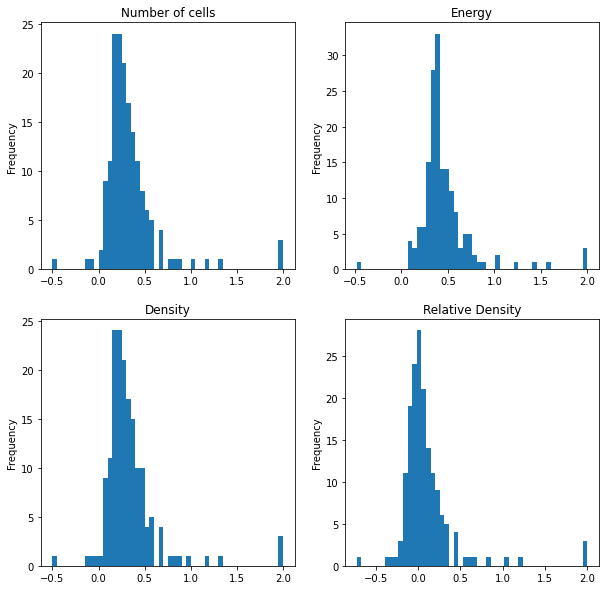

In [41]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
weighted_difference['n_cells'].plot(kind='hist',ax=axes[0][0],bins=50)
weighted_difference['energy'].plot(kind='hist',ax=axes[0][1],bins=50)
weighted_difference['density'].plot(kind='hist',ax=axes[1][0],bins=50)
weighted_difference['relative_density'].plot(kind='hist', ax=axes[1][1],bins=50)
axes[0][0].set_title('Number of cells')
axes[0][1].set_title('Energy')
axes[1][0].set_title('Density')
axes[1][1].set_title('Relative Density')

In [42]:
np.abs(weighted_difference['n_cells']).sort_values()[-60:]

area
Lateral preoptic area                                   0.468293
Superior colliculus sensory related                     0.469934
Septofimbrial nucleus                                   0.480769
Ventral part of the lateral geniculate complex          0.483770
Central linear nucleus raphe                            0.492754
Interanterodorsal nucleus of the thalamus               0.500000
Suprachiasmatic nucleus                                 0.500000
Edinger-Westphal nucleus                                0.500000
Presubiculum                                            0.515528
Postsubiculum                                           0.523077
Median preoptic nucleus                                 0.536585
Nucleus sagulum                                         0.540541
Retrochiasmatic area                                    0.560000
Fasciola cinerea                                        0.567335
Rhomboid nucleus                                        0.571429
Periventricular hypo

In [43]:
weighted_difference['n_cells'].sort_values()[0:30]

area
Suprachiasmatic nucleus                                 -0.500000
Central medial nucleus of the thalamus                  -0.125000
Lateral terminal nucleus of the accessory optic tract   -0.080000
Perireunensis nucleus                                    0.000000
Submedial nucleus of the thalamus                        0.042553
Arcuate hypothalamic nucleus                             0.055249
Ventral anterior-lateral complex of the thalamus         0.057143
Anteroventral periventricular nucleus                    0.080000
Peripeduncular nucleus                                   0.080000
Tuberomammillary nucleus                                 0.080000
Ventromedial hypothalamic nucleus                        0.088496
Parasubthalamic nucleus                                  0.094382
Globus pallidus internal segment                         0.095335
Lateral dorsal nucleus of thalamus                       0.095745
Visceral area                                            0.102181
Orbit

Text(0, 0.5, 'log(region volume)')

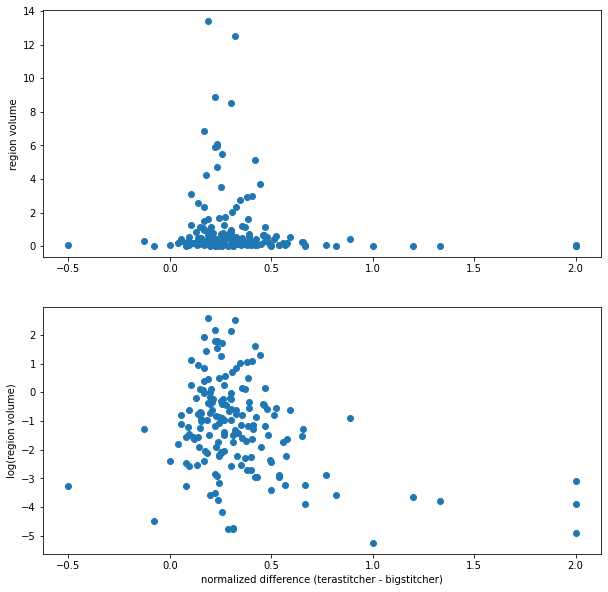

In [45]:
# Plot difference n_cells in function of the volume
vols = [volumes[volumes['safe_name']==area]['CCF_volume'].values[0] for area in difference['n_cells'].index]

fig, axes = plt.subplots(2,1, figsize=(10,10))
axes[0].scatter(y=vols, x=weighted_difference['n_cells'])
axes[1].scatter(y=np.log(vols), x=weighted_difference['n_cells'])
axes[1].set_xlabel('normalized difference (terastitcher - bigstitcher)')
axes[0].set_ylabel('region volume')
axes[1].set_ylabel('log(region volume)')

# Conclusion

The analysis and visualizations above provide insights into the performance and accuracy of different stitching algorithms. Further investigations could include exploring other metrics or using different datasets to validate these findings.
